# E-Commerce Events History in Electronics Store

## 1. Summary 

In this project, we will go through an ecommerce store that sells electronic products. I analyzed the data as if I were the store manager and tried to glean insights from it in order to determine action points. 

Here are the final actions points that can be generated from our data:

1. The high view count compared to the relatively low card and purchase t1.ransaction counts suggests that the company may be experiencing a problem with their conversion rate.

2. The electronics category shows a significant difference between view count and card/purchase transaction prices, indicating that the pricing for the electronics catalog may not be accurate.

3. In the computers category, customers tend to view cheaper products but buy more expensive ones, suggesting that there may be an opportunity to sell bundle items.

4. Although lighting products are being viewed extensively, they are not being purchased, which may indicate a pricing issue. Offering discounts on these items could potentially generate more sales.

5. CPU products rank 4th in purchase transactions, but they are not among the top 5 most viewed items. This implies that customers may not be able to find these products easily, and the store should work on improving their visibility.

6. Sales exhibit strong seasonality, with purchases increasing during holiday seasons. However, there are also significant differences in sales patterns between different days of the week and hours of the day, which should be taken into account when planning promotional activities.

## 2. Data Preparation and Cleaning

### 2.a Data Preparation

In [172]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Please click here to see / unsee the code."></form>''')

We are starting by importing the necessary libraries. Our original data is in CSV format, and we are using the Pandas library to read it. 

Since our original data has 885K rows and is too large, it may create computational problems. 

Therefore, we will use a sample of 200K rows instead.

In [173]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

import os
from IPython.display import Image, display, HTML

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import plotly.express as px

In [174]:
# Reading the data
data = pd.read_csv('data/events_history_electronics.csv')
data.shape

(885129, 9)

In [175]:
#Getting a sample 200K from the original data set. Reset index to avoid any confusion
sample_df = data.sample(n=200000, random_state = 42)
sample_df = sample_df.reset_index()
sample_df.drop('index', axis=1, inplace=True)

### 2.b Data Cleaning

In [176]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     200000 non-null  object 
 1   event_type     200000 non-null  object 
 2   product_id     200000 non-null  int64  
 3   category_id    200000 non-null  int64  
 4   category_code  146457 non-null  object 
 5   brand          151971 non-null  object 
 6   price          200000 non-null  float64
 7   user_id        200000 non-null  int64  
 8   user_session   199958 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 13.7+ MB


In [177]:
 #Checking null values
sample_df.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    53543
brand            48029
price                0
user_id              0
user_session        42
dtype: int64

In [178]:
sample_df.head()

event_time event_type  product_id          category_id  \
0  2020-11-01 14:36:11 UTC       view     4156279  2144415922587172973   
1  2020-10-04 13:48:49 UTC       view     1283611  2144415952391898012   
2  2020-10-25 06:27:19 UTC       view     3791351  2144415926966026460   
3  2021-01-12 08:26:56 UTC       view     3957221  2144415922427789416   
4  2020-11-26 12:29:34 UTC       view      227145  2144415921085612102   

                     category_code brand   price              user_id  \
0            electronics.telephone   NaN   12.22  1515915625533221908   
1    appliances.environment.vacuum  bort  170.00  1515915625469806973   
2         computers.components.cpu   amd  204.29  1515915625530210252   
3  computers.components.videocards  asus  451.32  1515915625592186998   
4                              NaN   NaN   13.00  1515915625544205939   

  user_session  
0   krDzDYA6J0  
1   C8YU0DjTP8  
2   GFm0pEaVjK  
3   E57Elq8HVE  
4   jvqzdCSUUw

We can see that our data is not too problematic. We only have three columns that have null values. The data types also appear consistent. However, our challenge with this data is that it is quite raw. To gain clear insights from it, we will need to perform extensive feature engineering. To do this, we will follow the steps outlined below:
    
1. Firstly, the category_code column contains very useful information, including not only category names but also subcategory and product names. We need to fill in any missing values and then split this column into three new columns to better understand its details.
    
2. Secondly, time series data can be especially helpful in exploring ecommerce dynamics, as customers may exhibit certain patterns when it comes to buying or viewing items.
    
3. Thirdly, we will need to drop some of the columns that do not provide insights relevant to this project.
    
4. Finally, we will rename the Event_type column to make it more self-explanatory.

**Filling the category code column**

We will fill in NaN category code rows based on their price. 

First, we will create a list of mean prices for every category code. 

Then, we will replace the NaN categories with the closest mean price category.


In [179]:
# Filling category column 

def mean_price(df, col):
    cat_price = {}
    for e in df[col].unique():
        cat_price[e] = np.mean(sample_df.loc[sample_df[col] == e, 'price'])
    return cat_price

mean_price_list = mean_price(sample_df,'category_code')

sample_df['category_code'].fillna('x', inplace=True)

for i, row in sample_df.iterrows():
    price = row['price']
    values = row['category_code']
    if values == 'x':
        closest_mean = min(mean_price_list.values(), key=lambda x: abs(x - price))
        closest_key = [k for k, v in mean_price_list.items() if v == closest_mean]
        values = str(closest_key[0])
        sample_df.at[i, 'category_code'] = values

**Spliting the category code column**

To better understand the category information in our data, we will split it into three columns: Category, Subcategory, and Product. 

Not every row will have information for all three columns, so we will assign "Not Available" to any missing values. 

It's worth noting that we have one additional value, "Piano", in the category column that is not useful for providing insights, so we will ignore it.

In [180]:
#Splitting the categories

split_category = sample_df['category_code'].apply(lambda x: str(x).split('.'))
sample_df['split_category'] = split_category

def extract_values(row):
    values = row['split_category']
    if len(values) >= 1:
        group = values[0]
    else:
        group = None
    if len(values) >= 2:
        category = values[1]
    else:
        category = None
    if len(values) >= 3:
        subcategory = values[2]
    else:
        subcategory = None
    return group, category, subcategory

sample_df[['category', 'subcategory', 'product']] = sample_df.apply(extract_values, axis=1, result_type='expand')

#Filling empty rows with nan
sample_df['category'] = sample_df['category'].fillna('not available')
sample_df['subcategory'] = sample_df['subcategory'].fillna('not available')
sample_df['product'] = sample_df['product'].fillna('not available')

#Dropping duplicate columns
sample_df = sample_df.drop('split_category', axis=1)
sample_df = sample_df.drop('category_code', axis=1)

**Converting event_time column**

We can see that our event time column contains information for the day, month, year, and time, all of which could be very useful for analysis. 

To make this information easier to work with, we will change the data type of this column to datetime and split it into new columns for each individual feature. 

In addition, we will create new columns indicating the day of the week and whether it is a weekend or not.

Finally, we will drop the original event time column since its information will be duplicated in the new columns we created.

In [181]:
#Converting event_time to date time

sample_df['event_time'] = pd.to_datetime(sample_df['event_time'], format='%Y-%m-%d %H:%M:%S %Z')

#Seperating event_time column to year, month and day
sample_df['year'] = sample_df['event_time'].dt.year
sample_df['month'] = sample_df['event_time'].dt.month
sample_df['day'] = sample_df['event_time'].dt.day
sample_df['hour'] = sample_df['event_time'].dt.hour
sample_df['day_of_week'] = sample_df['event_time'].dt.dayofweek
sample_df['day_of_week'] = sample_df['day_of_week'].replace({0:'monday',1:'tuesday',2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday',6:'sunday'})
sample_df['weekend'] = np.where(((sample_df['day_of_week'] == 'sunday') | (sample_df['day_of_week'] == 'saturday')),'yes','no' )

#Droping duplicate event_time column

sample_df.drop('event_time', axis=1, inplace=True)

cols=["year","month","day"]
sample_df['year_month_day'] = sample_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

sample_df['year_month_day'] = pd.to_datetime(sample_df['year_month_day'])

**Dropping columns**

We will drop the product_id and category_id columns since we will be using the new category columns we created. 

Additionally, we will drop the brand column since 25% of its values are missing, and brand level analysis is not a focus of this project. 

Finally, we will also drop the user_id and user_session columns since our analysis will be focused on categorical level data.

In [182]:
#Dropping columns

sample_df.drop('brand', axis=1, inplace=True)
sample_df.drop('product_id', axis=1, inplace=True)
sample_df.drop('category_id', axis=1, inplace=True)
sample_df.drop('user_id', axis=1, inplace=True)
sample_df.drop('user_session', axis=1, inplace=True)

**Changing event_type column name**

Finally, we will rename the event_type column to 'transaction' since the current column name is not clear for the unique values in this column. 

The column has only 3 unique values: view, cart, and purchase, and from an e-commerce perspective, the term 'transaction' would be more descriptive.

In [183]:
#Changing event_type column name to transaction
sample_df.rename(columns={'event_type':'transaction'}, inplace=True)

After making all of these changes, our data is now ready to be analyzed. We have cleaned the data, performed feature engineering, and can now extract insights more easily.

In [184]:
sample_df.head()

transaction   price     category  subcategory        product  year  month  \
0        view   12.22  electronics    telephone  not available  2020     11   
1        view  170.00   appliances  environment         vacuum  2020     10   
2        view  204.29    computers   components            cpu  2020     10   
3        view  451.32    computers   components     videocards  2021      1   
4        view   13.00  accessories    briefcase  not available  2020     11   

   day  hour day_of_week weekend year_month_day  
0    1    14      sunday     yes     2020-11-01  
1    4    13      sunday     yes     2020-10-04  
2   25     6      sunday     yes     2020-10-25  
3   12     8     tuesday      no     2021-01-12  
4   26    12    thursday      no     2020-11-26

## 3. Explatory Data Analysis

### 3.a Analyzing Category and Price

We will begin our analysis by examining the category values, transactions, prices, and their interrelationships.

In [185]:
sample_df[['transaction','category','subcategory','product']].describe(include='all').T

count unique            top    freq
transaction  200000      3           view  179291
category     200000     14      computers   80511
subcategory  200000     42     components   48264
product      200000     77  not available   64467

Our dataset contains three unique types of transactions: views, card, and purchases. Views are the most common transaction type, accounting for almost 90% of the total count. This suggests that the store should focus on improving its conversion rate (CVR), as most customers are only browsing the items. 

The store sells 14 different categories of products, with the computer category being the most popular. 

Additionally, there are 42 unique subcategories and 77 unique products. However, the most popular product is 'Not Available,' indicating that most products only have a category and subcategory available.

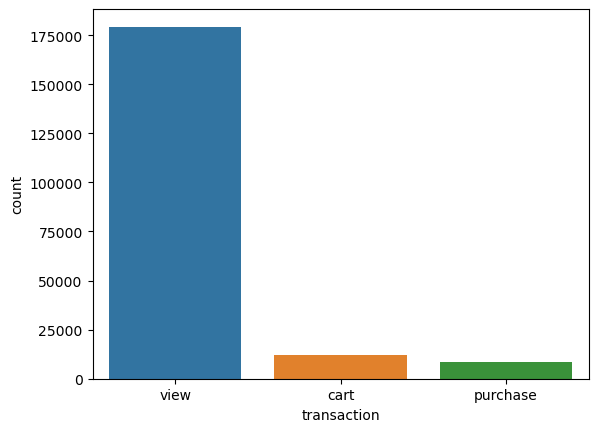

In [186]:
sns.countplot(sample_df['transaction'], order=['view','cart','purchase']);

The difference between the number of cart and purchase transactions is smaller compared to the number of view transactions. This suggests that people are more likely to make a purchase once they have added items to their cart

In [187]:
cat_counts = sample_df.groupby('category')['transaction'].count().reset_index(name='Total Transaction')
cat_counts = cat_counts.sort_values('Total Transaction', ascending=False)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Category', 'Total Transaction', 'Transaction Share %'],
                line_color='coral',
                fill_color='coral',
                align='left'),
    cells=dict(values=[cat_counts['category'],
                       cat_counts['Total Transaction'],
                       round((cat_counts['Total Transaction'] / len(sample_df['transaction'])) * 100, 2)],
               line_color='coral',
               fill_color='cornsilk',
               align='left'
               ))])

fig = fig.update_layout(
        title= 'Total Transaction Count per Category')

fig.show()



The top three categories account for 70% of all transactions, with the computer category being the flagship category of this electronics store. 

However, this could potentially be risky, as any issues related to the supply of computers or other factors could greatly impact the store's ability to operate successfully.

In [188]:
table = pd.pivot_table(data=sample_df,index='category',columns='transaction',aggfunc = 'size')
table['total'] = table.sum(axis=1)
table = table.sort_values(by='total', ascending=False)
table = table.reindex(columns=['view','cart','purchase','total'])
print(table)

transaction    view  cart  purchase  total
category                                  
computers     69744  6585      4182  80511
electronics   38859  2225      1614  42698
appliances    17535   712       517  18764
auto          14679   711       515  15905
stationery    10426   817       719  11962
construction  10854   512       353  11719
accessories    4522   172       111   4805
country_yard   3810   104        76   3990
furniture      3272   181        88   3541
apparel        2885   172       132   3189
jewelry        1863    96        59   2018
medicine        460    18        18    496
kids            191     4         6    201
sport           191     8         2    201


The distribution of categories and their transaction counts are similar, suggesting that the high number of views and lower number of cart and purchase transactions are not specific to a particular category, but rather a general issue for the store.  This is something that we will investigate further. 

One of the main factors behind this behavior could be price, as it often determines customers' buying behavior. Therefore, we will begin our analysis by examining the prices

In [189]:
sample_df['price'].describe()

count    200000.000000
mean        145.886815
std         263.787375
min           0.220000
25%          26.460000
50%          65.400000
75%         190.460000
max       42590.130000
Name: price, dtype: float64

In [190]:
fig = go.Figure(
    go.Histogram(
        x=sample_df['price'],
        xbins={
            'start':0,
            'end' :1500,
            'size':50
        },
        marker_color= 'pink',
        opacity = 0.6)
)

fig = fig.update_layout(
        title= 'Price Distribution',
        xaxis_title ='Price',
        yaxis_title = 'Count')


fig.show()

The large standard deviation and range of values suggest that the variable is highly skewed and possibly contains outliers. This skewness can also be observed in the price distribution graph. Although there is some variation in the prices, the differences between the quartiles are not too high when compared to the minimum and maximum values. 

Generally, the products fall within a certain price range, but there are also some really expensive products in this store's catalog. This is not surprising, given the nature of electronics items.

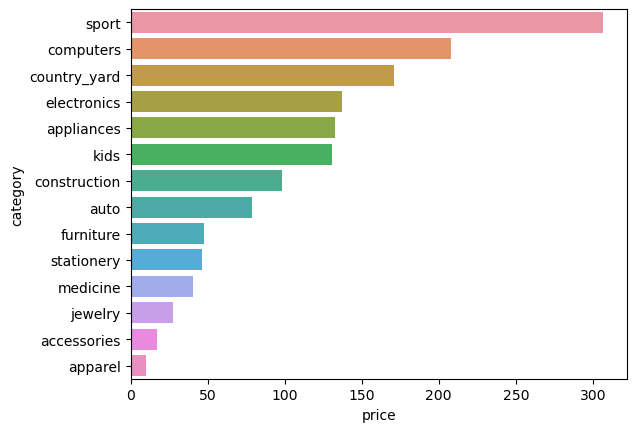

In [191]:
grouped_price_df = sample_df.groupby(by='category')['price'].mean()
grouped_price_df = grouped_price_df.reset_index()
grouped_price_df = grouped_price_df.sort_values(by='price', ascending=False)
sns.barplot(x='price', y='category', data=grouped_price_df, orient='h');

Within the sports category, we observed that the only available subcategory is bicycles, which also happens to contain the most expensive products in the store. 

In terms of price range, we noticed that the difference between the first two categories, namely computers and bicycles, is significantly larger than that of the other categories. 

This suggests that the store may be targeting customers with different budgets for the sport category. After sport, the prices of the remaining categories appear to decrease more steadily.

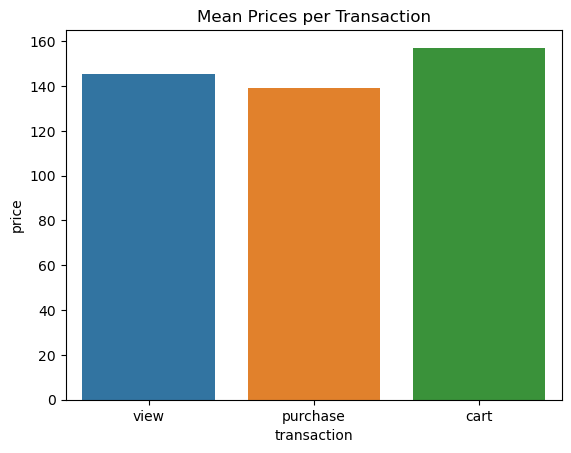

In [192]:
sns.barplot(data=sample_df,x='transaction',y='price',ci=False)
plt.title('Mean Prices per Transaction');

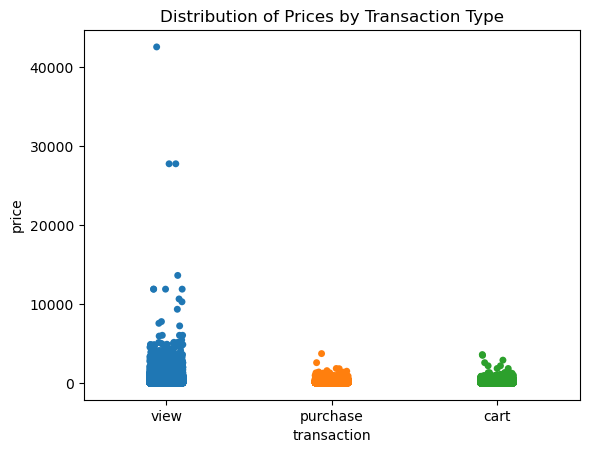

In [193]:
sns.stripplot(data=sample_df,x='transaction',y='price')
plt.title('Distribution of Prices by Transaction Type');

We observed that the mean price for items in the cart transaction type is the highest among all transaction types. This is contrary to what we would normally expect, as we would typically assume that prices for items viewed by customers would be more expensive than those added to their cart. We will further investigate this unusual behavior and explore the possible reasons behind it.

We also examined the distribution of prices by transaction type and found that there are fewer outliers for purchase and cart transactions, while view transactions have a larger number of extremely expensive items. This indicates that customers who only view items may be looking at more premium or high-end products, which could be contributing to the higher prices observed in this transaction type. Further analysis of prices by category may help shed light on where these high prices are coming from and whether they are representative of the broader trends across the store's product offerings.

In [194]:
sample_df.groupby(by=['category','transaction'])['price'].mean().head(30)

category      transaction
accessories   cart            16.034709
              purchase        14.013333
              view            16.947988
apparel       cart             9.793837
              purchase         9.779015
              view             9.939390
appliances    cart           113.090604
              purchase       101.191412
              view           134.056689
auto          cart            69.046835
              purchase        67.438777
              view            79.282776
computers     cart           229.612419
              purchase       212.242826
              view           205.949387
construction  cart            93.984824
              purchase        92.674249
              view            98.446891
country_yard  cart           157.270385
              purchase        87.629079
              view           173.002958
electronics   cart            78.868944
              purchase        72.455347
              view           143.139329
furniture     

We have important take aways from this data.

1. For cheap categories like accessories, apparel, and jewelry, the price differences between transactions are not that high. This could suggest that customers in these categories are less price sensitive and may be more willing to make a purchase even if the price difference is relatively small. However, it's important to note that this might not hold true for all customers in these categories, as some may still be price conscious and actively seek out the best deals.

2. In contrast, the electronics category has a higher price gap between viewed items and cart/purchase transactions, which suggests that customers in this category may be more price sensitive or the store pricing for electronics category is not very accurate. For example, they might browse high-priced items but ultimately decide not to buy them. This means that there may be opportunities to incentivize customers to make a purchase, such as by offering discounts on high-priced items that have a high view count but low sales return.

3. The same could be said for categories like yard and appliances, although these categories may not be as strong as electronics in terms of customer price sensitivity. For these categories, it might be worth exploring ways to incentivize customers to make purchases, such as by offering promotions or discounts on items that have high view counts but low sales returns.

4. Observations of customer behavior in the computers category reveal a noteworthy trend: customers tend to view cheaper products but add more expensive items to their carts. Additionally, the mean purchase price is lower than the average cart price. It's possible that customers are holding out for discounts before making a purchase, which could be addressed by targeting customers who have items in their carts for an extended period of time and offering them specific discounts.Another possible explanation for the price difference between views and purchases is that customers may be doing their due diligence by examining available products before making a purchase. To leverage this behavior, retailers could consider creating bundle deals that combine higher-priced items with necessary, lower-priced products.

Ultimately, these insights demonstrate that pricing and promotion strategies should be tailored to the unique characteristics of each category. By understanding customer behavior and preferences, retailers can better incentivize purchases and increase revenue.

In [195]:
@interact
def price_transaction_categories(column=list(sample_df['category'].unique())):
    display(HTML(f'<h2>Prices for subcategory {column}<h2>'))
    pivot_table = pd.pivot_table(
        sample_df[sample_df['category'] == column], 
        values='price', 
        index='subcategory', 
        columns='transaction',
        aggfunc=np.mean)
    display(pivot_table)

interactive(children=(Dropdown(description='column', options=('electronics', 'appliances', 'computers', 'acces…

**Product Examination**

In [215]:
filtered_df = sample_df[sample_df['product'] != 'not available']
filtered_df[filtered_df['transaction'] == 'view'].groupby('product')['transaction'].count().sort_values(ascending=False).head()

product
videocards     21842
printer         9124
light           6092
acoustic        5650
motherboard     5453
Name: transaction, dtype: int64

In [216]:
filtered_df[filtered_df['transaction'] == 'cart'].groupby('product')['transaction'].count().sort_values(ascending=False).head()

product
videocards     2885
printer         730
cpu             516
motherboard     496
light           336
Name: transaction, dtype: int64

In [217]:
filtered_df[filtered_df['transaction'] == 'purchase'].groupby('product')['transaction'].count().sort_values(ascending=False).head()

product
videocards     1566
printer         604
motherboard     298
cpu             262
light           235
Name: transaction, dtype: int64

1. When examining the product data, it was found that many customers are viewing light products, but they are not among the top 5 products for cart and purchase. This could suggest that customers are hesitant to purchase these products due to their perceived high price point. To address this issue, the store could consider offering discounts or promotions on these products to incentivize customers to make a purchase. By focusing on products with high view numbers and low unit sales, the store can target customers who have already shown an interest in these items and encourage them to take the next step towards a purchase.

2. On the other hand, CPU products have proven to be popular among customers, ranking among the top 5 items for both cart and purchase. However, these products are not among the top-viewed items, indicating that there may be an opportunity to increase their visibility and drive more sales. The store should prioritize promoting these products, using tactics such as paid advertising, social media campaigns, or prominent placement on the website. Additionally, optimizing the product pages with detailed descriptions and customer reviews can help to enhance their appeal to potential buyers. By taking a proactive approach to increasing impressions and sales of these products, the store can maximize their revenue potential in this category.

### 3.b Analyzing Dates

In [235]:
temp_df = sample_df.groupby(['year_month_day','weekend'])['transaction'].count().reset_index()

# Using plotly.express
import plotly.express as px
df = temp_df
fig = px.line(df, x='year_month_day', y='transaction')


fig.show()

Firstly, it's important to note that the sales data for September is incomplete, so we will focus on the sales data from October 2020.

In the graph, we observe that the transaction pattern displays cyclic behavior with strong seasonality. As we approach the Christmas and New Year season, the sales start to increase, but during that period, they decrease sharply before picking up again. This cyclic behavior may indicate a pattern in consumer behavior, such as increased shopping during the holiday season. The strong seasonality could also suggest that there are external factors influencing sales, such as holidays or events. It would be beneficial to investigate the factors contributing to these cyclic behaviors and seasonality further to optimize sales and marketing strategies accordingly.

In [207]:
df = sample_df.groupby(['weekend', 'transaction'])['transaction'].count().reset_index(name='count')
fig = px.bar(df, x="weekend", y="count",
             color='transaction', barmode='group',
             height=600, title='Weekend vs Transaction')
fig.show()

The data clearly shows a decrease in transactions on weekends compared to weekdays. This could be attributed to a number of factors, such as customers having more free time during weekends to physically visit stores, resulting in less online shopping. Additionally, customers may be more likely to complete their online purchases during the workweek when they have access to their work computers and free time during breaks.

Another possible explanation is that weekends tend to be associated with relaxation and leisure time, while online shopping may be seen as a more work-oriented activity. As a result, customers may be less inclined to engage in online shopping activities during weekends.

Overall, these findings suggest that the store should consider tailoring their marketing strategies and promotional activities to weekdays, when customers are more likely to be active online shoppers. This could include offering weekday-specific promotions or targeting customers with marketing campaigns during peak weekday shopping hours.

In [209]:
sorted_df = sample_df.copy()
sorted_df['day_of_week'] = pd.Categorical(sorted_df['day_of_week'], categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)
sorted_df = sorted_df.sort_values('day_of_week')
df = sorted_df.groupby(['day_of_week', 'transaction'])['transaction'].count().reset_index(name='count')

fig = px.line(df, x='day_of_week',y='count',color='transaction', title= 'Day of week vs Transaction')

fig.show()

Although there is a slight decrease in view numbers on Saturdays, it is not a significant drop. Mondays tend to have the highest viewing numbers, followed by a gradual decrease throughout the week until Saturday, when it starts to increase again on Sundays. 

However, cart and purchase behaviors show a more distinct pattern. On Fridays, there is an increase in items being added to carts, but purchase counts are decreasing. This could suggest that customers are adding items to their carts as part of their weekend shopping plans but are waiting for potential discounts or promotions before making a purchase. On Saturdays, there is a more noticeable decrease in items being added to carts, which could be attributed to customers being more active and busy on the weekend and thus having less time for online shopping.

To address the decrease in cart activity on weekends, the store could consider running special promotions or deals exclusively on weekends to entice customers to make purchases during that time. Offering free shipping, a limited-time discount, or a special bundle deal could help increase weekend cart activity and ultimately lead to more purchases. Another possible strategy to encourage sales is to target customers who add items to their carts on Fridays with discounts or special offers. This could incentivize them to make a purchase over the weekend.

Additionally, the store could optimize its website for mobile devices, as many customers may be browsing on their phones or tablets during the weekend. Streamlining the checkout process and making it easier for customers to complete their purchases on mobile devices could also help boost weekend sales.

In [211]:
df = sample_df.groupby(['hour', 'transaction'])['transaction'].count().reset_index(name='count')

fig = px.line(df, x="hour", y="count",
             color='transaction', title='Transaction per hour')
fig.show()

When we check hourly data, we can observe a distinct pattern that follows a typical sleeping schedule. Specifically, transaction volumes decrease at night, which is indicative of reduced activity during the sleeping hours.

Furthermore, our analysis highlights significant differences between card and purchase transactions throughout the day. Notably, the hour of 11:00 am is associated with the highest card transaction volumes, while purchase transactions decrease during this period. Additionally, there is a small peak in purchase transactions at 4:00 pm. However, at 5:00 pm, we observe an increase in both card and purchase transactions, making it a potentially lucrative time to launch a marketing campaign.

## 4. Conclusion and Further Analysis

For this project, we conducted an analysis of an ecommerce store selling electronics items. The initial data we received was relatively clean but not detailed enough to derive useful insights. Therefore, we began an extensive process of feature engineering, extracting date and time information and treating categorical values separately.

As a result of our analysis, we have gained useful insights into product categories and specific items that require pricing and visibility adjustments. Additionally, we have gained an understanding of the patterns of timely data and sales seasonality.

While our analysis focused on the categorical level, future analysis could be conducted at the brand level to determine individual brand performance. Moreover, incorporating user information could provide better insights into user behavior.